In [44]:
from flask import Flask, jsonify, request
from app.models.User import User 
from app.models.SubscriptionEvent import SubscriptionEvent 
from app.models.db import session
import io
from app.schemas.User import UserSchema
from app.schemas.SubscriptionEvent import SubscriptionEventSchema
import pandas as pd
from datetime import date
from flask import Response
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sqlalchemy.orm import joinedload
import seaborn as sns

sns.set()

def calculate_age(bdate):
    if bdate:
        bdate = pd.to_datetime(bdate)
        today = date.today()
        return today.year - bdate.year - ((today.month, today.day) < (bdate.month, bdate.day))

def fig_to_response(fig):
    output = io.BytesIO()
    FigureCanvas(fig).print_png(output)
    return Response(output.getvalue(), mimetype='image/png')

def get_current_subscribers(Subscription):
    subquery = session.\
        query(Subscription.user_id, func.max(Subscription.date)).\
            group_by(Subscription.user_id).all()
    query = session.\
        query(Subscription.id, Subscription.user_id, Subscription.user_id, Subscription.date).\
            filter(tuple_(Subscription.user_id, Subscription.date).in_(list(subquery)), Subscription.is_subscribed==True)
    return query.all()

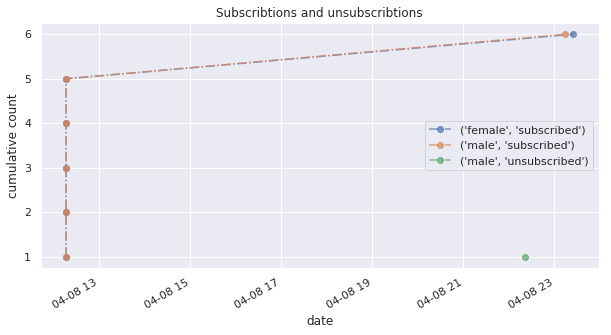

In [71]:

min_date = datetime.now()-timedelta(days=100)

subscription_events = session.query(SubscriptionEvent).\
    filter(SubscriptionEvent.date >= min_date).\
        options(joinedload(SubscriptionEvent.user)).all()

schema = SubscriptionEventSchema()
subscription_events = schema.dump(subscription_events, many=True)
subscription_events = pd.DataFrame(subscription_events)
subscription_events.index  = pd.to_datetime(subscription_events["date"])
subscription_events["age"] = subscription_events["user"].apply(lambda x: calculate_age(x["bdate"]))
subscription_events["sex"] = subscription_events["user"].apply(lambda x: "female" if x["sex"]==1 else "male")
subscription_events["is_subscribed"] = subscription_events["is_subscribed"].apply(lambda x: "subscribed" if x else "unsubscribed")
subscription_events["is_subscribed"] = subscription_events["is_subscribed"].sort_index()

subscription_events["cumcount"] = subscription_events.groupby(["sex", "is_subscribed"]).cumcount() + 1

fig, ax = plt.subplots(figsize=(10,5))
for label, df in subscription_events.groupby(["sex", "is_subscribed"]):    
    df["cumcount"].plot(ax=ax, label=f"{label}", style="-.o", alpha=0.7)
plt.legend()
plt.ylabel("cumulative count")
plt.title("Subscribtions and unsubscribtions")
plt.show()

response = fig_to_response(fig)

In [68]:
subscription_events["sex"].value_counts()

2    7
1    6
Name: sex, dtype: int64

In [ ]:
import requests
group_id = 193519310
access_token 
post_id = 
params = {'access_token': access_token,
          'v': 5.73, 
          "owner_id":-group_id, 
          "post_id": post_id, 
          "max_count":200, 
          "offset": 0}

r = requests.get('https://api.vk.com/method/wall.getReposts', params=params)